# Parameter sweep for LBI predictor

Load flu tip attributes and final clade frequencies and then calculate the error of an exponential growth model based on just the LBI predictor across a range of predictor coefficients. The goal is to determine the shape of the error function that is exposed to scipy's optimization machinery.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys

%matplotlib inline

In [2]:
pwd

'/Users/jlhudd/projects/nextstrain/flu-forecasting/analyses'

In [3]:
sys.path.insert(0, "../src")

In [4]:
from fit_model import DistanceExponentialGrowthModel, sum_of_differences
from weighted_distances import get_distances_by_sample_names

In [5]:
sns.set_style("white")
plt.style.use("huddlej")

In [6]:
mpl.rcParams['savefig.dpi'] = 200
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['font.weight'] = 300
mpl.rcParams['axes.labelweight'] = 300
mpl.rcParams['font.size'] = 18

## Load data

Define the range of possible coefficient values to explore.

In [7]:
coefficients = np.linspace(-2, 2, 31)

In [8]:
delta_time = 1.0
l1_lambda = 0.0

In [9]:
last_timepoint = pd.to_datetime("2023-10-01")

In [10]:
distances = pd.read_csv(
    "../results/builds/simulated/simulated_sample_1/target_distances.tsv",
    sep="\t"
)

In [11]:
distances_by_sample = get_distances_by_sample_names(distances)

In [12]:
# Load tip attributes.
X = pd.read_csv(
    "../results/builds/simulated/simulated_sample_1/tip_attributes_with_weighted_distances.tsv",
    sep="\t",
    parse_dates=["timepoint"]
)

In [13]:
X.columns

Index(['strain', 'aa_sequence', 'branch_length', 'clade_membership',
       'clock_length', 'date', 'delta_frequency', 'dms', 'dms_entropy',
       'dms_nonepitope', 'dms_star', 'ep', 'ep_star', 'ep_wolf', 'ep_x', 'lbi',
       'mutation_length', 'ne', 'ne_star', 'normalized_fitness', 'numdate',
       'raw_date', 'rb', 'sequence', 'generation', 'fitness', 'num_date',
       'date_metadata', 'year', 'month', 'is_terminal', 'timepoint', 'lineage',
       'segment', 'kde_frequency', 'diffusion_frequency', 'frequency', 'naive',
       'weighted_distance_to_present', 'weighted_distance_to_future',
       'log2_distance_effect'],
      dtype='object')

In [14]:
X = X.loc[:, ["strain", "clade_membership", "timepoint", "lbi", "frequency",
              "weighted_distance_to_present", "weighted_distance_to_future",
              "normalized_fitness", "ne_star", "ep", "ne", "ep_x"]].copy()

In [15]:
X.head()

,strain,clade_membership,timepoint,lbi,frequency,weighted_distance_to_present,weighted_distance_to_future,normalized_fitness,ne_star,ep,ne,ep_x
0,sample_3216_6,ed6c203,2016-10-01,0.025256,0.000012,8.354777,11.569858,0.921286,1.0,7,8,-5.841661
1,sample_3220_1,caaed87,2016-10-01,0.023693,0.000019,11.354576,14.666101,0.861260,3.0,8,10,-5.466963
2,sample_3224_10,173672f,2016-10-01,0.114689,0.000031,5.429236,8.927039,1.000000,0.0,8,8,-5.487380
3,sample_3224_3,b2e8133,2016-10-01,0.022227,0.000031,9.120933,12.878575,0.850147,1.0,8,8,-5.477516
4,sample_3224_5,b0db357,2016-10-01,0.137004,0.000031,9.422183,12.926953,0.583550,3.0,8,12,-5.536284


In [16]:
X.shape

(2361, 12)

In [17]:
X = X[~pd.isnull(X["weighted_distance_to_present"])].copy()

In [18]:
X.timepoint.unique()

array(['2016-10-01T00:00:00.000000000', '2017-04-01T00:00:00.000000000',
       '2017-10-01T00:00:00.000000000', '2018-04-01T00:00:00.000000000',
       '2018-10-01T00:00:00.000000000', '2019-04-01T00:00:00.000000000',
       '2019-10-01T00:00:00.000000000', '2020-04-01T00:00:00.000000000',
       '2020-10-01T00:00:00.000000000', '2021-04-01T00:00:00.000000000',
       '2021-10-01T00:00:00.000000000', '2022-04-01T00:00:00.000000000',
       '2022-10-01T00:00:00.000000000', '2023-04-01T00:00:00.000000000',
       '2023-10-01T00:00:00.000000000', '2024-04-01T00:00:00.000000000',
       '2024-10-01T00:00:00.000000000', '2025-04-01T00:00:00.000000000',
       '2025-10-01T00:00:00.000000000', '2026-04-01T00:00:00.000000000',
       '2026-10-01T00:00:00.000000000', '2027-04-01T00:00:00.000000000',
       '2027-10-01T00:00:00.000000000', '2028-04-01T00:00:00.000000000',
       '2028-10-01T00:00:00.000000000', '2029-04-01T00:00:00.000000000',
       '2029-10-01T00:00:00.000000000', '2030-04-01

In [19]:
X.shape

(2361, 12)

In [20]:
X["y"] = X["weighted_distance_to_future"]

In [21]:
y = X.loc[:, ["strain", "timepoint", "y", "frequency", "weighted_distance_to_future"]].copy()

In [22]:
y["timepoint"] = y["timepoint"] - pd.DateOffset(months=12)

In [23]:
X.head()

,strain,clade_membership,timepoint,lbi,frequency,weighted_distance_to_present,weighted_distance_to_future,normalized_fitness,ne_star,ep,ne,ep_x,y
0,sample_3216_6,ed6c203,2016-10-01,0.025256,0.000012,8.354777,11.569858,0.921286,1.0,7,8,-5.841661,11.569858
1,sample_3220_1,caaed87,2016-10-01,0.023693,0.000019,11.354576,14.666101,0.861260,3.0,8,10,-5.466963,14.666101
2,sample_3224_10,173672f,2016-10-01,0.114689,0.000031,5.429236,8.927039,1.000000,0.0,8,8,-5.487380,8.927039
3,sample_3224_3,b2e8133,2016-10-01,0.022227,0.000031,9.120933,12.878575,0.850147,1.0,8,8,-5.477516,12.878575
4,sample_3224_5,b0db357,2016-10-01,0.137004,0.000031,9.422183,12.926953,0.583550,3.0,8,12,-5.536284,12.926953


In [24]:
y.head()

,strain,timepoint,y,frequency,weighted_distance_to_future
0,sample_3216_6,2015-10-01,11.569858,0.000012,11.569858
1,sample_3220_1,2015-10-01,14.666101,0.000019,14.666101
2,sample_3224_10,2015-10-01,8.927039,0.000031,8.927039
3,sample_3224_3,2015-10-01,12.878575,0.000031,12.878575
4,sample_3224_5,2015-10-01,12.926953,0.000031,12.926953


In [25]:
X = X[X["timepoint"] <= last_timepoint - pd.DateOffset(months=12)]

In [26]:
X.tail()

,strain,clade_membership,timepoint,lbi,frequency,weighted_distance_to_present,weighted_distance_to_future,normalized_fitness,ne_star,ep,ne,ep_x,y
1053,sample_4540_3,088ed06,2022-10-01,0.158157,0.038686,17.422598,19.776754,0.750162,7.0,8,15,-5.027956,19.776754
1054,sample_4540_4,385136e,2022-10-01,0.157593,0.038686,11.416403,10.662670,0.887758,3.0,9,12,-4.840017,10.662670
1055,sample_4544_1,a0ccf9a,2022-10-01,0.245533,0.039815,10.830025,8.561469,0.702695,5.0,9,14,-4.847654,8.561469
1056,sample_4544_4,00c606f,2022-10-01,0.156751,0.039815,8.316428,9.736741,0.963067,0.0,7,8,-5.529079,9.736741
1057,sample_4548_7,21cb024,2022-10-01,0.299007,0.040393,9.768678,7.561848,0.841115,3.0,8,12,-4.892441,7.561848


In [27]:
X.shape

(1058, 13)

In [28]:
X.timepoint.unique()

array(['2016-10-01T00:00:00.000000000', '2017-04-01T00:00:00.000000000',
       '2017-10-01T00:00:00.000000000', '2018-04-01T00:00:00.000000000',
       '2018-10-01T00:00:00.000000000', '2019-04-01T00:00:00.000000000',
       '2019-10-01T00:00:00.000000000', '2020-04-01T00:00:00.000000000',
       '2020-10-01T00:00:00.000000000', '2021-04-01T00:00:00.000000000',
       '2021-10-01T00:00:00.000000000', '2022-04-01T00:00:00.000000000',
       '2022-10-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [29]:
X.timepoint.unique().shape

(13,)

## Inspect true fitness model

Text(0,0.5,"Earth mover's distance")

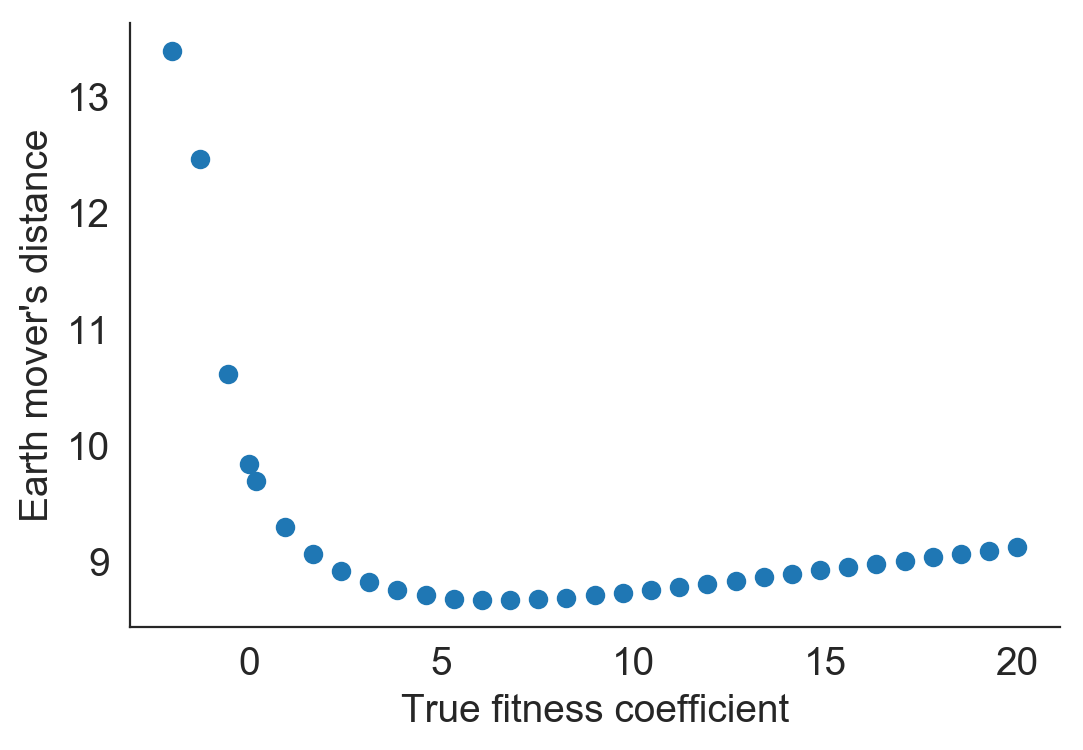

In [30]:
coefficients = np.array(sorted(list(np.linspace(-2, 20, 31)) + [0.]))
predictors = ["normalized_fitness"]
l1_lambda = 0.0

model = DistanceExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_differences,
    distances=distances_by_sample
)
model.mean_stds_ = model.calculate_mean_stds(X, model.predictors)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

plt.plot(coefficients, errors, "o")
plt.xlabel("True fitness coefficient")
plt.ylabel("Earth mover's distance")
#plt.xlim(-1, 1)

In [31]:
coefficients[np.argmin(errors)]

6.066666666666666

In [32]:
errors[np.where(coefficients == 0)[0][0]] - min(errors)

1.1753835311302776

## Inspect LBI model

Text(0,0.5,"Earth mover's distance")

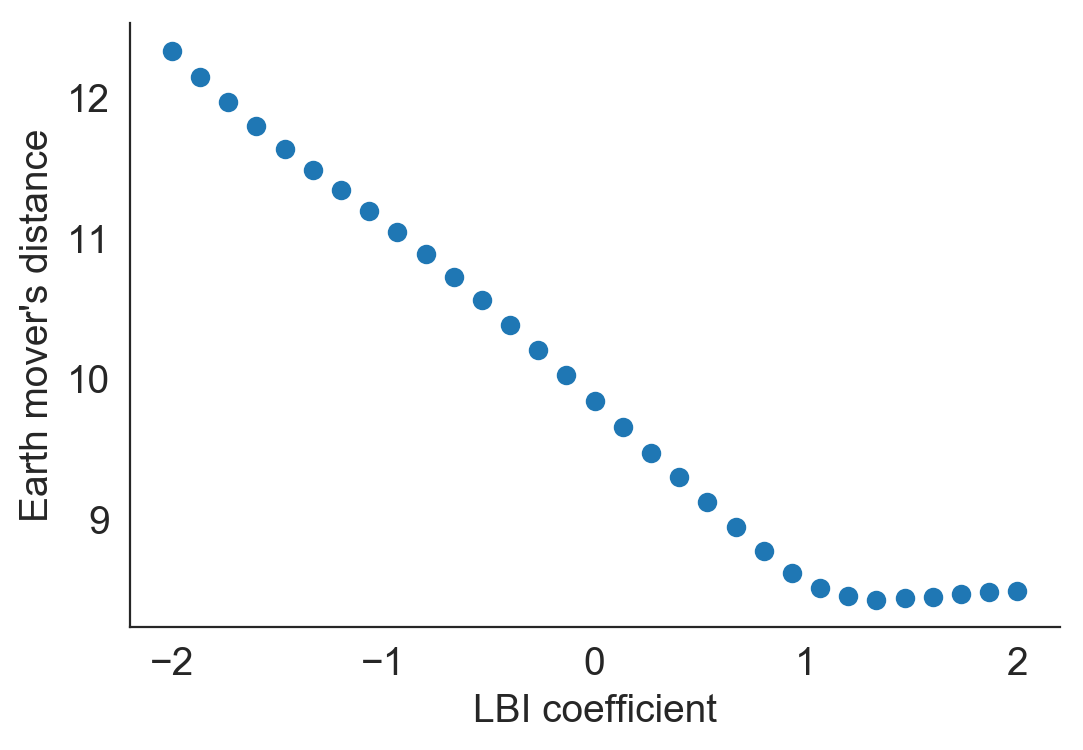

In [33]:
coefficients = np.linspace(-2, 2, 31)
predictors = ["lbi"]
l1_lambda = 0.0

model = DistanceExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_differences,
    distances=distances_by_sample
)
model.mean_stds_ = model.calculate_mean_stds(X, model.predictors)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

plt.plot(coefficients, errors, "o")
plt.xlabel("LBI coefficient")
plt.ylabel("Earth mover's distance")
#plt.xlim(-1, 1)

In [34]:
min(errors)

8.431238687955416

In [35]:
coefficients[np.argmin(errors)]

1.3333333333333335

In [36]:
errors[np.where(coefficients == 0)[0][0]] - min(errors)

1.4139395860525283

## Inspect non-epitope mutations

Text(0,0.5,"Earth mover's distance")

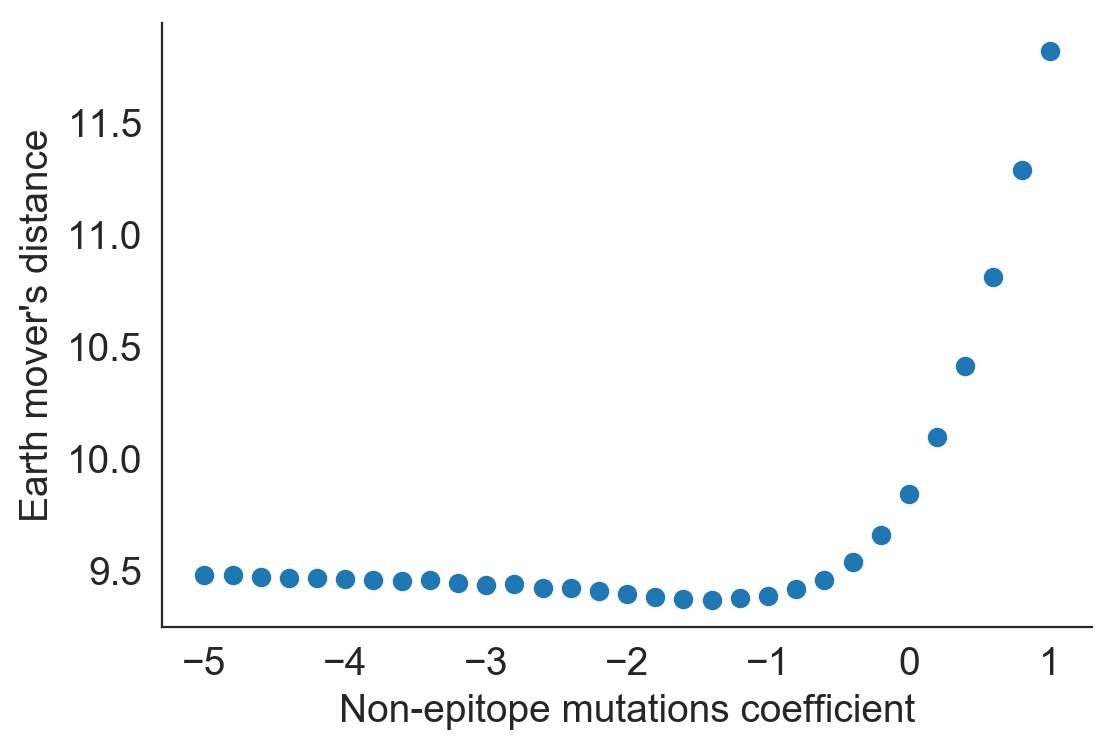

In [37]:
coefficients = np.linspace(-5, 1, 31)
predictors = ["ne_star"]
l1_lambda = 0.0

model = DistanceExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_differences,
    distances=distances_by_sample
)
model.mean_stds_ = model.calculate_mean_stds(X, model.predictors)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

plt.plot(coefficients, errors, "o")
plt.xlabel("Non-epitope mutations coefficient")
plt.ylabel("Earth mover's distance")
#plt.xlim(-1, 1)

In [38]:
coefficients[np.argmin(errors)]

-1.4

In [39]:
errors[np.where(coefficients == 0)[0][0]] - min(errors)

0.47366318335899926

## Inspect epitope cross-immunity

Text(0,0.5,"Earth mover's distance")

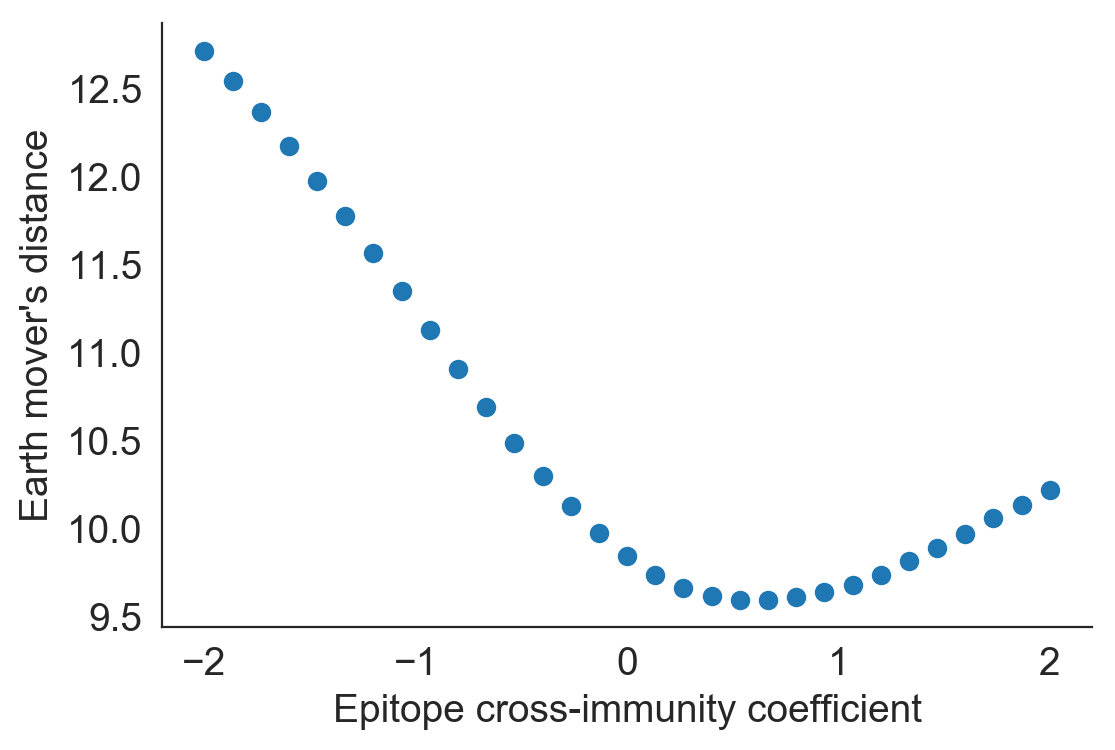

In [40]:
coefficients = np.linspace(-2, 2, 31)
predictors = ["ep_x"]
l1_lambda = 0.0

model = DistanceExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_differences,
    distances=distances_by_sample
)
model.mean_stds_ = model.calculate_mean_stds(X, model.predictors)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

plt.plot(coefficients, errors, "o")
plt.xlabel("Epitope cross-immunity coefficient")
plt.ylabel("Earth mover's distance")
#plt.xlim(-1, 1)

In [41]:
coefficients[np.argmin(errors)]

0.6666666666666665

In [42]:
errors[np.where(coefficients == 0)[0][0]] - min(errors)

0.2461874668414783

## Inspect cTiterSub model

In [ ]:
predictors = ["cTiterSub_x"]
l1_lambda = 0.5

model = DistanceExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_differences,
    distances=distances_by_sample
)
model.mean_stds_ = model.calculate_mean_stds(X, model.predictors)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

plt.plot(coefficients, errors, "o")
plt.xlabel("cTiterSub_x coefficient")
plt.ylabel("Weighted distance")

In [ ]:
min(errors)

In [ ]:
coefficients[np.argmin(errors)]

## Inspect epitope count model

In [ ]:
predictors = ["ep"]
l1_lambda = 0.5

model = DistanceExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_differences,
    distances=distances_by_sample
)
model.mean_stds_ = model.calculate_mean_stds(X, model.predictors)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

plt.plot(coefficients, errors, "o")
plt.xlabel("ep coefficient")
plt.ylabel("Weighted distance")

In [ ]:
min(errors)

In [ ]:
coefficients[np.argmin(errors)]

## Inspect epitope cross-immunity model

In [ ]:
predictors = ["ep_x"]

model = DistanceExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_differences,
    distances=distances_by_sample
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

plt.plot(coefficients, errors, "o")
plt.xlabel("Epitope cross-immunity model coefficient")
plt.ylabel("Weighted distance")

In [ ]:
min(errors)

In [ ]:
coefficients[np.argmin(errors)]

## Inspect delta frequency model

In [ ]:
predictors = ["delta_frequency"]
l1_lambda = 0.5

model = DistanceExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_differences,
    distances=distances_by_sample
)
model.mean_stds_ = model.calculate_mean_stds(X, model.predictors)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

plt.plot(coefficients, errors, "o")
plt.xlabel("delta frequency coefficient")
plt.ylabel("Weighted distance")

In [ ]:
min(errors)

In [ ]:
coefficients[np.argmin(errors)]

## Inspect two-parameter models

In [ ]:
predictors = ["lbi", "cTiterSub_x"]

model = DistanceExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_differences,
    distances=distances_by_sample
)

In [ ]:
len(coefficients)

In [ ]:
errors_by_first_coefficient = {}
for coefficient_i in coefficients:
    errors = []
    for coefficient_j in coefficients:
        error = model._fit([coefficient_i, coefficient_j], X, y)
        errors.append(error)
    
    errors_by_first_coefficient[coefficient_i] = errors

In [ ]:
fig, axes = plt.subplots(6, 4, figsize=(20, 20), gridspec_kw={"hspace": 0.75}, sharey=True)

for ci, coefficient_i in enumerate(sorted(errors_by_first_coefficient.keys())):
    ax = axes.flatten()[ci]
    
    errors = errors_by_first_coefficient[coefficient_i]
    ax.plot(coefficients, errors, "o")
    ax.set_xlabel("Titer substitution model coefficient")
    ax.set_ylabel("Weighted distance")
    ax.set_title("LBI coefficient: %.2f" % coefficient_i)

In [ ]:
predictors = ["lbi", "cTiterSub_x"]
delta_time = 1.0
l1_lambda = 0.0

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=mean_absolute_error
)

records = []
errors_by_first_coefficient = {}
for coefficient_i in coefficients:
    errors = []
    for coefficient_j in coefficients:
        error = model._fit([coefficient_i, coefficient_j], X, y)
        errors.append(error)
        records.append({
            "lbi": coefficient_i,
            "cTiterSub": coefficient_j,
            "error": error
        })
    
    errors_by_first_coefficient[coefficient_i] = errors

In [ ]:
records_df = pd.DataFrame(records)
records_df.sort_values("error").head()

In [ ]:
fig, axes = plt.subplots(6, 4, figsize=(20, 20), gridspec_kw={"hspace": 0.75}, sharey=True)

for ci, coefficient_i in enumerate(sorted(errors_by_first_coefficient.keys())):
    ax = axes.flatten()[ci]
    
    errors = errors_by_first_coefficient[coefficient_i]
    ax.plot(coefficients, errors, "o")
    ax.set_xlabel("Titer substitution model coefficient")
    ax.set_ylabel("MAE")
    ax.set_title("LBI coefficient: %.2f" % coefficient_i)